# Imports

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

# Configuration

In [2]:
class CFG:
    verbose = 1
    seed = 42  
    neg_sample = 0.01 
    pos_sample = 5.0  
    preset = "efficientnetv2_b2_imagenet"  
    image_size = [128, 128] 
    epochs = 8 
    batch_size = 256 
    lr_mode = "cos" 
    class_names = ['target']
    num_classes = 1

In [3]:
keras.utils.set_random_seed(CFG.seed)

In [4]:
BASE_PATH = "/kaggle/input/isic-2024-challenge"

In [5]:

df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')
df = df.ffill()
display(df.head(2))


testing_df = pd.read_csv(f'{BASE_PATH}/test-metadata.csv')
testing_df = testing_df.ffill()
display(testing_df.head(2))

<ipython-input-5-0e4ff20c12dd>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/forma

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY


# Class Imbalance

In [6]:
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Sampling
positive_df = df.query("target==0").sample(frac=CFG.neg_sample, random_state=CFG.seed)
negative_df = df.query("target==1").sample(frac=CFG.pos_sample, replace=True, random_state=CFG.seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nCalss Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

Class Distribution Before Sampling (%):


target
0    99.902009
1     0.097991
Name: proportion, dtype: float64


Calss Distribution After Sampling (%):


target
0    67.09645
1    32.90355
Name: proportion, dtype: float64

## Class Weight

In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.7451959071624656, 1: 1.519592875318066}


# Load Images

In [8]:
import h5py

training_validation_hdf5 = h5py.File(f"{BASE_PATH}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{BASE_PATH}/test-image.hdf5", 'r')

## Data Split

In [9]:
from sklearn.model_selection import StratifiedGroupKFold

df = df.reset_index(drop=True)
df["fold"] = -1
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)
for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.patient_id)):
    df.loc[validation_idx, "fold"] = int(i)

# Use first fold for training and validation
training_df = df.query("fold!=0")
validation_df = df.query("fold==0")
print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")

# Num Train: 4706 | Num Valid: 1266


In [10]:
training_df.target.value_counts()

target
0    3088
1    1618
Name: count, dtype: int64

In [11]:
validation_df.target.value_counts()

target
0    919
1    347
Name: count, dtype: int64

# Tabular Features

In [12]:

CATEGORICAL_COLUMNS = ["sex", "anatom_site_general",
            "tbp_tile_type","tbp_lv_location", ]

NUMERIC_COLUMNS = ["age_approx", "tbp_lv_nevi_confidence", "clin_size_long_diam_mm",
           "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio", "tbp_lv_color_std_mean",
           "tbp_lv_deltaLBnorm", "tbp_lv_minorAxisMM", ]

FEAT_COLS = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS

# DataLoader

In [13]:
def build_augmenter():
    aug_layers = [
        keras_cv.layers.RandomCutout(height_factor=(0.02, 0.06), width_factor=(0.02, 0.06)),
        keras_cv.layers.RandomFlip(mode="horizontal"),
    ]
    
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        # Read jpeg image
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, CFG.num_classes)
        return (inp, label)

    return decode_with_labels if with_labels else decode_image


def build_dataset(
    isic_ids,
    hdf5,
    features,
    labels=None,
    batch_size=32,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    shuffle=1024,
    cache=True,
    drop_remainder=False,
):
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    images = [None]*len(isic_ids)
    for i, isic_id in enumerate(tqdm(isic_ids, desc="Loading Images ")):
        images[i] = hdf5[isic_id][()]
        
    inp = {"images": images, "features": features}
    slices = (inp, labels) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## Training & Validation Dataset

In [14]:
## Train
print("# Training:")
training_features = dict(training_df[FEAT_COLS])
training_ids = training_df.isic_id.values
training_labels = training_df.target.values
training_ds = build_dataset(training_ids, training_validation_hdf5, training_features, 
                         training_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=True)

# Valid
print("# Validation:")
validation_features = dict(validation_df[FEAT_COLS])
validation_ids = validation_df.isic_id.values
validation_labels = validation_df.target.values
validation_ds = build_dataset(validation_ids, training_validation_hdf5, validation_features,
                         validation_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)


# Training:


Loading Images :   0%|          | 0/4706 [00:00<?, ?it/s]

# Validation:


Loading Images :   0%|          | 0/1266 [00:00<?, ?it/s]

In [15]:
feature_space = keras.utils.FeatureSpace(
    features={
        # Categorical features encoded as integers
        "sex": "string_categorical",
        "anatom_site_general": "string_categorical",
        "tbp_tile_type": "string_categorical",
        "tbp_lv_location": "string_categorical",
        # Numerical features to discretize
        "age_approx": "float_discretized",
        # Numerical features to normalize
        "tbp_lv_nevi_confidence": "float_normalized",
        "clin_size_long_diam_mm": "float_normalized",
        "tbp_lv_areaMM2": "float_normalized",
        "tbp_lv_area_perim_ratio": "float_normalized",
        "tbp_lv_color_std_mean": "float_normalized",
        "tbp_lv_deltaLBnorm": "float_normalized",
        "tbp_lv_minorAxisMM": "float_normalized",
    },
    output_mode="concat",
)

In [16]:
training_ds_with_no_labels = training_ds.map(lambda x, _: x["features"])
feature_space.adapt(training_ds_with_no_labels)

In [17]:
for x, _ in training_ds.take(1):
    preprocessed_x = feature_space(x["features"])
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (256, 71)
preprocessed_x.dtype: <dtype: 'float32'>


In [18]:
training_ds = training_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": feature_space(x["features"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

validation_ds = validation_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": feature_space(x["features"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

## Output Shape of a Batch

Verifying the shape of a batch sample is essential. This step ensures that the dataloader is generating inputs with the correct dimensions, which is critical for the model's performance.

In [19]:
batch = next(iter(validation_ds))

print("Images:",batch[0]["images"].shape)
print("Features:", batch[0]["features"].shape)
print("Targets:", batch[1].shape)

Images: (256, 128, 128, 3)
Features: (256, 71)
Targets: (256, 1)


# Loss & Metric

In [20]:
# ACC
auc = keras.metrics.Accuracy()

loss = keras.losses.BinaryCrossentropy(label_smoothing=0.02)

# Modeling

In [21]:

image_input = keras.Input(shape=(*CFG.image_size, 3), name="images")
feat_input = keras.Input(shape=(feature_space.get_encoded_features().shape[1],), name="features")
inp = {"images":image_input, "features":feat_input}


backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)
x1 = backbone(image_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)


x2 = keras.layers.Dense(96, activation="selu")(feat_input)
x2 = keras.layers.Dense(128, activation="selu")(x2)
x2 = keras.layers.Dropout(0.1)(x2)


concat = keras.layers.Concatenate()([x1, x2])


out = keras.layers.Dense(1, activation="sigmoid", dtype="float32")(concat)


model = keras.models.Model(inp, out)


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=["accuracy"],
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)       │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ features (InputLayer)     │ (None, 71)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficient_net_v2b2_backb… │ (None, 4, 4, 1408)     │      8,769,374 │ images[0][0]           │
│ (EfficientNetV2Backbone)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 96)             │          6,912 │ features[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1408)           │              0 │ efficient_net_v2b2_ba… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         12,416 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1408)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1536)           │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │          1,537 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,790,239 (33.53 MB)

 Trainable params: 8,707,951 (33.22 MB)

 Non-trainable params: 82,288 (321.44 KB)

## Plot Model

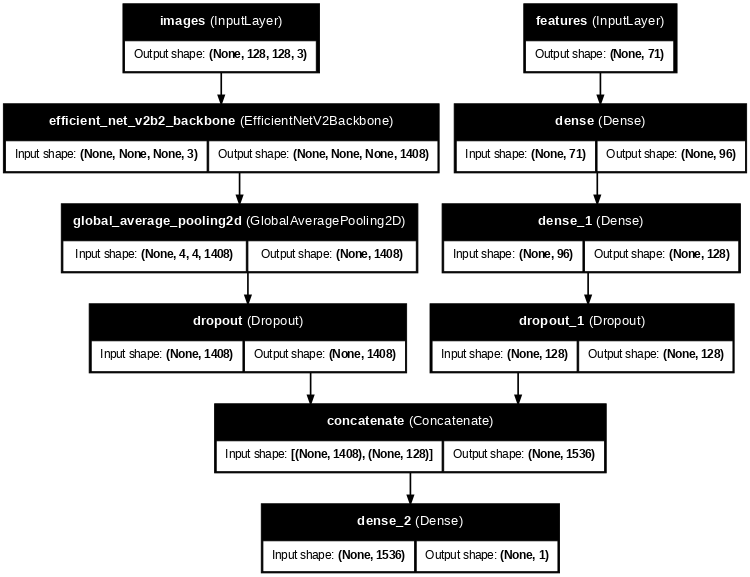

In [22]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)

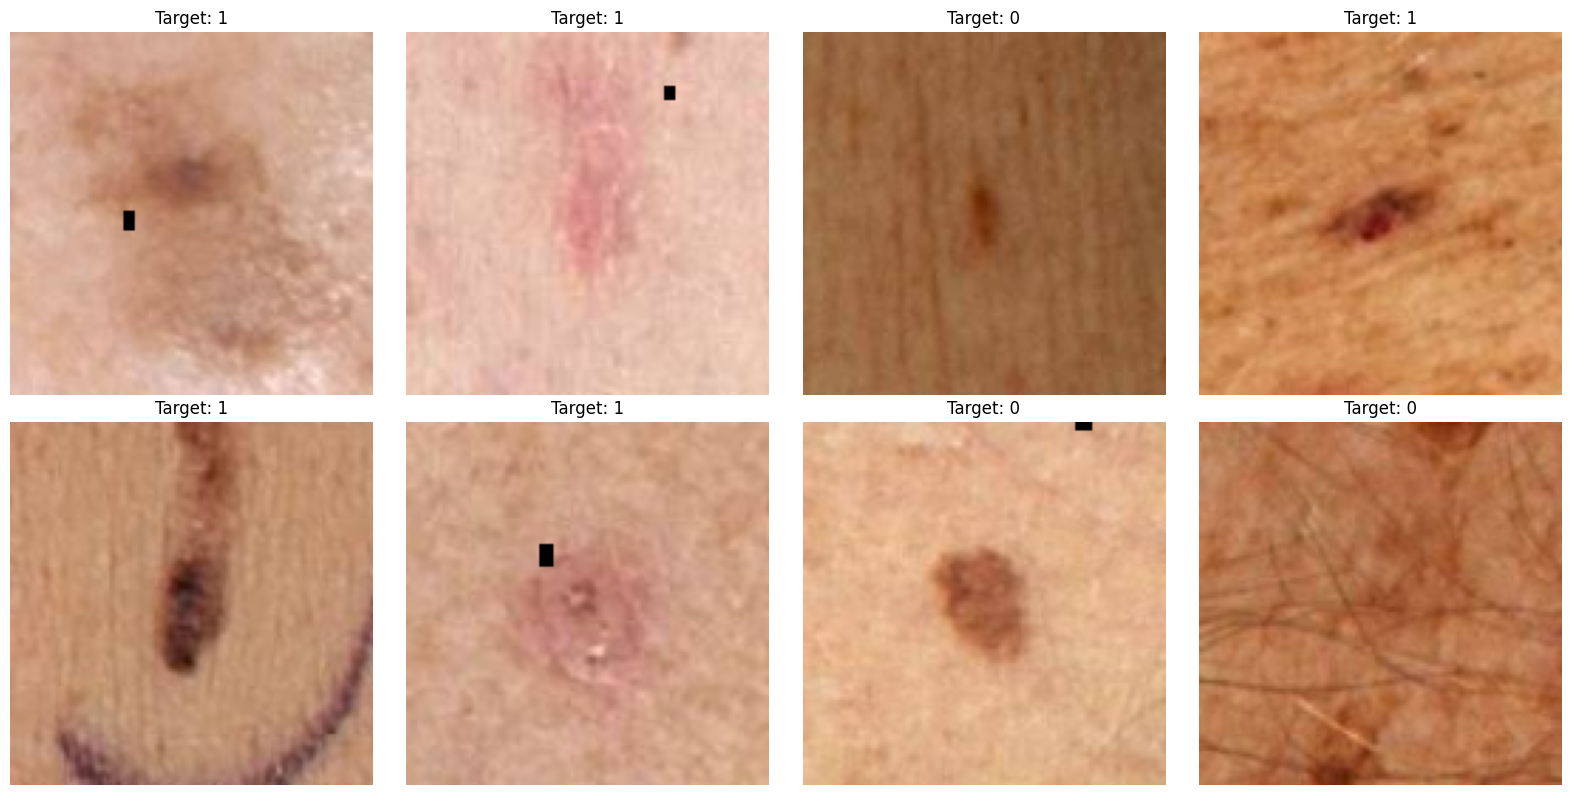

In [23]:
inputs, targets = next(iter(training_ds))
images = inputs["images"]
num_images, NUMERIC_COLUMNS = 8, 4

plt.figure(figsize=(4 * NUMERIC_COLUMNS, num_images // NUMERIC_COLUMNS * 4))
for i, (image, target) in enumerate(zip(images[:num_images], targets[:num_images])):
    plt.subplot(num_images // NUMERIC_COLUMNS, NUMERIC_COLUMNS, i + 1)
    image = image.numpy().astype("float32")
    target= target.numpy().astype("int32")[0]
    
    image = (image - image.min()) / (image.max() + 1e-4)

    plt.imshow(image)
    plt.title(f"Target: {target}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [24]:
history = model.fit(
    training_ds,
    epochs=CFG.epochs,
    validation_data=validation_ds,
    verbose=CFG.verbose,
    class_weight=class_weights,
)

Epoch 1/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.4692 - loss: 0.7173 - val_accuracy: 0.2741 - val_loss: 0.8396
Epoch 2/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 418ms/step - accuracy: 0.7498 - loss: 0.5629 - val_accuracy: 0.5032 - val_loss: 0.6879
Epoch 3/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 421ms/step - accuracy: 0.8363 - loss: 0.4407 - val_accuracy: 0.7536 - val_loss: 0.5343
Epoch 4/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 427ms/step - accuracy: 0.8705 - loss: 0.3599 - val_accuracy: 0.8262 - val_loss: 0.4504
Epoch 5/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - accuracy: 0.8946 - loss: 0.2969 - val_accuracy: 0.8657 - val_loss: 0.3395
Epoch 6/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 432ms/step - accuracy: 0.9148 - loss: 0.2412 - val_accuracy: 0.8618 - val_loss: 0.3421
Epoch 7/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 430ms/step - accuracy: 0.9241 - loss: 0.2028 - val_accuracy: 0.8570 - val_loss: 0.3453
Epoch 8/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 441ms/step - accuracy: 0.9451 - loss: 0.1618 - val_accuracy: 0.8673 - 

## Build Testing Dataset

In [25]:

print("# Testing:")
testing_features = dict(testing_df[FEAT_COLS])
testing_ids = testing_df.isic_id.values
testing_ds = build_dataset(testing_ids, testing_hdf5,
                        testing_features, batch_size=CFG.batch_size,
                         shuffle=False, augment=False, cache=False)

testing_ds = testing_ds.map(
    lambda x: {"images": x["images"],
               "features": feature_space(x["features"])}, num_parallel_calls=tf.data.AUTOTUNE)

# Testing:


Loading Images :   0%|          | 0/3 [00:00<?, ?it/s]

## Inference

In [26]:
preds = model.predict(testing_ds).squeeze()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


## Prediction

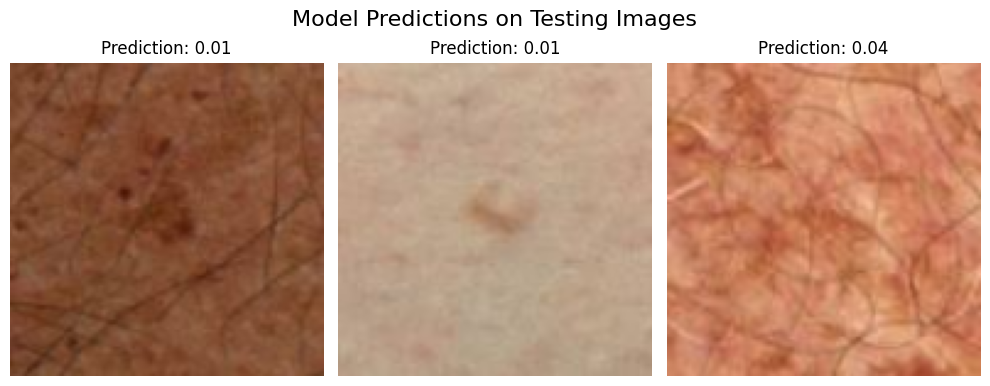

In [27]:
inputs = next(iter(testing_ds))
images = inputs["images"]

# Plotting
plt.figure(figsize=(10, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)  
    plt.imshow(images[i])  
    plt.title(f'Prediction: {preds[i]:.2f}')  
    plt.axis('off')  

plt.suptitle('Model Predictions on Testing Images', fontsize=16)
plt.tight_layout()
plt.show()